In [27]:
# !pip install pandas scipy pandas
#!pip install --upgrade https://github.com/EmilWine/gpuRIR/zipball/master
# !pip3 install scikit-image


In [68]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

from math import ceil
import librosa
import librosa.display
import gpuRIR
import scipy.signal as signal
import pandas as ps
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d as mp3d
from ipywidgets import *
from scipy.optimize import linear_sum_assignment
from multiprocessing import Manager, Pool
from skimage.feature.peak import peak_local_max

%matplotlib nbagg

In [29]:
%matplotlib nbagg

In [30]:
## Source Array positions
room_sz = [3,2.2,2.5]  # Size of the room [m]
pos_src = np.array([[0.6,0.7,1.0]]) # Positions of the sources ([m]
pos_rcv = np.vstack((pos_src+np.array([[-0.1,0,0]]),
                   pos_src+np.array([[0.1,0,0]])))

In [31]:
orV_rcv = np.matlib.repmat(np.array([0,1,0]), len(pos_rcv), 1) 
# Vectors pointing in the same direction than the receivers
mic_pattern = "omni" # Receiver polar pattern
abs_weights = [1.0]*5+[1.0] # Absortion coefficient ratios of the walls
T60 = 1.0 # Time for the RIR to reach 60dB of attenuation [s] 
att_diff = 5.0 # Attenuation when start using the diffuse reverberation model [dB]
att_max = 60.0 # Attenuation at the end of the simulation [dB]
Tw = 3 #samples window -  This is the smearing factor
fs=48000*2 # Sampling frequency [Hz]
c = 343

In [32]:
## Helper functions
def envelope(sig_in): 
    return np.abs(signal.hilbert(sig_in))

def energy_decay(rir):
    e_rir = np.cumsum(np.abs(rir)**2)
    e_rir = e_rir[-1] - e_rir
    e_rir /= e_rir[0]
    return e_rir

def tvec(vec,fs,centered=False): 
    temp_time = 1000*np.arange(len(vec)) / fs
    if centered:
        temp_time -= np.mean(temp_time)
    return temp_time

def window_framing(arr,win_size,win_step):
    framed = []
    idx = 0
    hann_window = signal.windows.hann(win_size)
    while idx <= len(arr) - win_size:
        framed.append(hann_window * arr[idx:(idx+win_size)].tolist())
        idx += win_step
    return np.array(framed).T


def to_db(vec):
    return 20*np.log10(np.abs(vec) + 1e-6)


# Display array configuraion

<IPython.core.display.Javascript object>


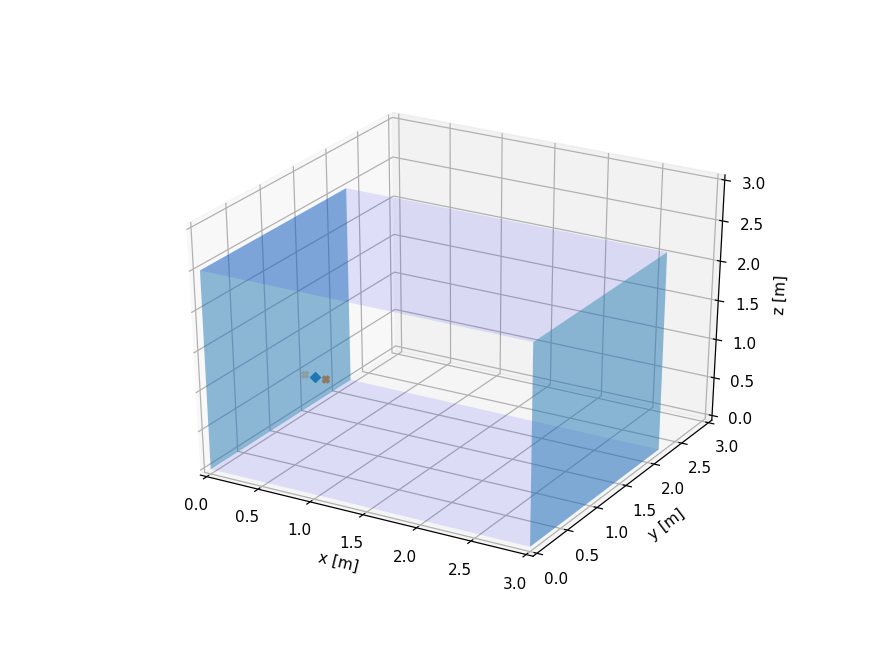

In [33]:
import matplotlib.pyplot as plt

wx,wy,wz = room_sz

bot = [(0, 0, 0),
       (wx, 0, 0),
       (wx, wy, 0),
       (0, wy, 0),
       ]

top =  [(0, 0, wz),
       (wx, 0, wz),
       (wx, wy, wz),
       (0, wy, wz),
       ]

p1 =  [(0, 0, wz),
       (0, wy, wz),
       (0, wy, 0),
       (0, 0, 0),
       ]

p2 =  [(wx, 0, wz),
       (wx, wy, wz),
       (wx, wy, 0),
       (wx, 0, 0),
       ]


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
face1 = mp3d.art3d.Poly3DCollection([bot], alpha=0.1, linewidth=1)
face2 = mp3d.art3d.Poly3DCollection([top], alpha=0.1, linewidth=1)
face3 = mp3d.art3d.Poly3DCollection([p1], alpha=0.5, linewidth=1)
face4 = mp3d.art3d.Poly3DCollection([p2], alpha=0.5, linewidth=1)
face1.set_facecolor((0, 0, 1))
face2.set_facecolor((0, 0, 1))

ax.scatter(pos_src[:,0],pos_src[:,1],pos_src[:,2],label="Sources",marker='D')
ax.scatter(pos_rcv[:,0],pos_rcv[:,1],pos_rcv[:,2],label="Receivers",marker='X')

ax.add_collection3d(face1)
ax.add_collection3d(face2)
ax.add_collection3d(face3)
ax.add_collection3d(face4)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_xlim([0,3])
ax.set_ylim([0,3])
ax.set_zlim([0,3])

plt.show()


In [34]:
beta = gpuRIR.beta_SabineEstimation(room_sz, T60, abs_weights=abs_weights) # Reflection coefficients
Tdiff= gpuRIR.att2t_SabineEstimator(att_diff, T60) # Time to start the diffuse reverberation model [s]
Tmax = gpuRIR.att2t_SabineEstimator(att_max, T60)	 # Time to stop the simulation [s]
nb_img = gpuRIR.t2n( Tdiff, room_sz )	# Number of image sources in each dimension


In [35]:
Taus = gpuRIR.simulateTaus(room_sz, beta, pos_src, pos_rcv, nb_img, fs, \
                           orV_rcv=orV_rcv, mic_pattern=mic_pattern,c=c)
RIRs = gpuRIR.simulateRIR(room_sz, beta, pos_src, pos_rcv, nb_img, Tmax,\
                          Tw, fs, Tdiff=Tdiff, orV_rcv=orV_rcv, mic_pattern=mic_pattern,c=c)

<IPython.core.display.Javascript object>


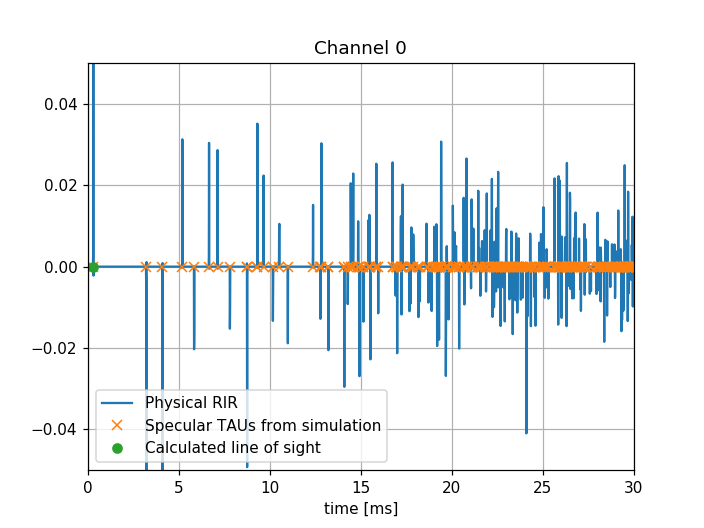

In [36]:
# t = np.arange(int(ceil(Tmax * fs))) / fs
t = tvec(RIRs[0,0,:],fs)
direct_tau = 1000*np.linalg.norm(pos_src - pos_rcv[0,:])/343

plt.figure()
plt.title("Channel 0")
plt.plot(t,RIRs[0,0,:],label = 'Physical RIR')
plt.plot(1000*Taus[0,0]/fs,[0]*len(Taus[0,0]),'x',label="Specular TAUs from simulation")
plt.plot(direct_tau,0,'o',label="Calculated line of sight")
plt.xlabel('time [ms]')
plt.legend()


plt.xlim([0,30])
plt.ylim([-0.05,0.05])
plt.grid()
plt.show()

In [37]:
## Calculate Optimal FFT window length

dmax = 0
for i in range(len(pos_rcv)):
    for j in range(len(pos_rcv)):
        dtmp = np.linalg.norm(pos_rcv[i,:]-pos_rcv[j,:])
        dmax = dmax if dmax > dtmp else dtmp

        
tau_max_ms = 1000*dmax/343

window_duration = 2*tau_max_ms + tau_max_ms #the extra is to avoid wrapping in cross correlation

Nhop = int(np.ceil(window_duration*fs/1000/4))
Nfft = Nhop * 4

print("FFT={0}, Hop={1}, Window time={2:.2f}ms".format(Nfft,Nhop,1000*Nfft/fs))

# dmax = np.linalg.norm(np.diff(pos_rcv,axis=0),axis=-1)

FFT=168, Hop=42, Window time=1.75ms


<IPython.core.display.Javascript object>


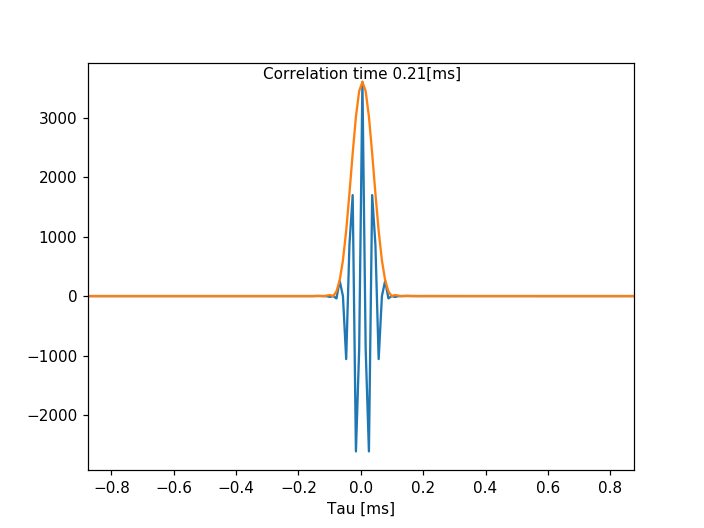

<IPython.core.display.Javascript object>


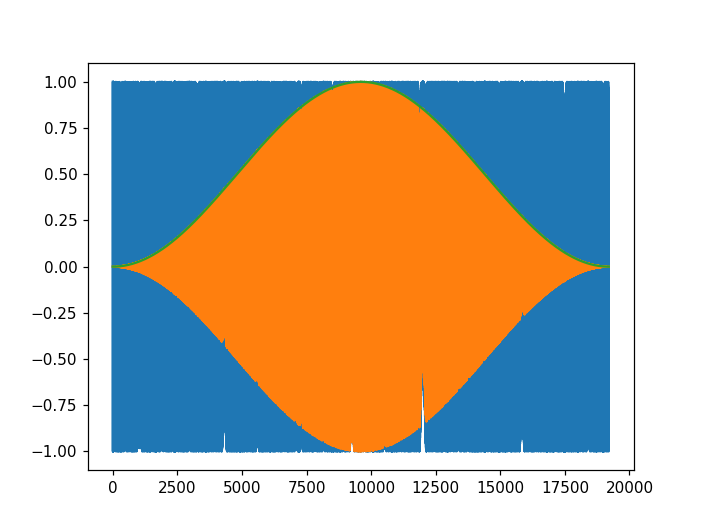

<IPython.core.display.Javascript object>


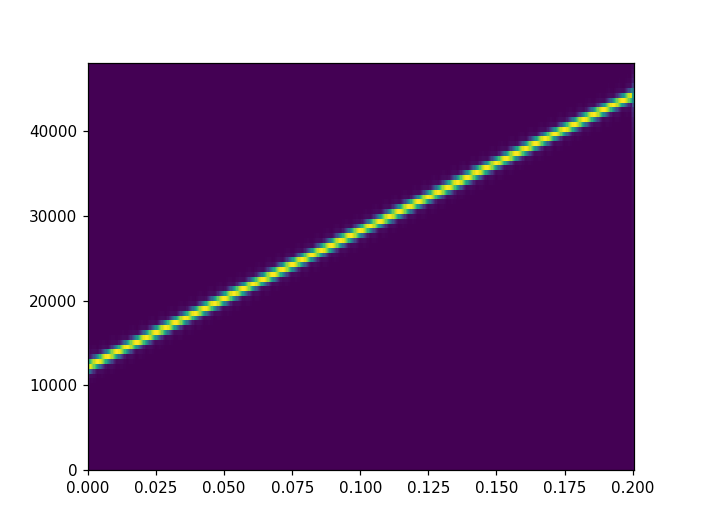

In [38]:
## Logchirp
t_probe = 0.2
t = np.arange(int(ceil(t_probe * fs))) / fs

fmin = 12000
fmax = 44000

probe_sig = signal.chirp(t,fmin,t_probe,fmax,method="linear")
window = signal.windows.hann(len(probe_sig))
probe_windowed = window*probe_sig
probe_corr = signal.correlate(probe_windowed,probe_windowed,'same')
probe_env = envelope(probe_corr)

m1 = np.sum(t*np.abs(probe_env))/np.sum(np.abs(probe_env))
m2 = np.sqrt(np.sum( ((t-m1)**2)*np.abs(probe_env))/np.sum(np.abs(probe_env)))
m1 -= np.mean(t)

peak_width_ms = 6*m2*1000

plt.figure()
plt.plot(1000*(t-np.mean(t)),probe_corr)
plt.plot(1000*(t-np.mean(t)),np.abs(probe_env))
plt.text(1000*m1,np.max(np.abs(probe_env)),"Correlation time {0:.2f}[ms]".format(peak_width_ms),\
         horizontalalignment='center',verticalalignment='bottom')
plt.xlim([-1000*Nfft/2/fs,1000*Nfft/2/fs])
plt.xlabel('Tau [ms]')

plt.figure()
plt.plot(probe_sig)
plt.plot(probe_windowed)
plt.plot(window)

freqs, times,probe_stft = signal.stft(probe_sig,fs=fs,nperseg=Nfft,noverlap=Nfft-Nhop,return_onesided=True)

plt.figure()
plt.pcolormesh(times,freqs,np.abs(probe_stft))
plt.show()





<IPython.core.display.Javascript object>


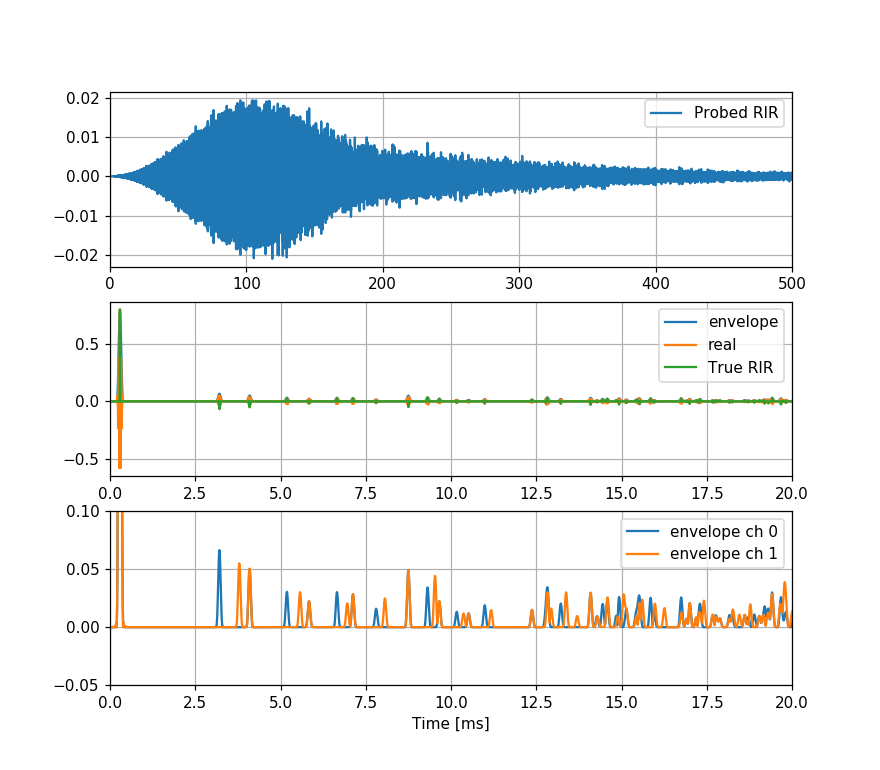

In [39]:
df = ps.DataFrame()

normed_probe_windowed = probe_windowed / np.linalg.norm(probe_windowed)
for src in range(len(pos_src)):
    for rcv in range(len(pos_rcv)):
        rir = RIRs[src,rcv,:]
        prir = signal.convolve(rir,normed_probe_windowed,'full',method="direct")
        ds_rir = np.flip(signal.convolve(np.flip(prir),normed_probe_windowed))[len(normed_probe_windowed)-1:]
        framed_rir = window_framing(ds_rir, Nfft,Nhop)
        _,_,stft_rir = signal.stft(RIRs[src,rcv,:],fs=fs,nperseg=Nfft,noverlap=Nfft-Nhop,return_onesided=False)
        _,_,stft_drir = signal.stft(ds_rir,fs=fs,nperseg=Nfft,noverlap=Nfft-Nhop,return_onesided=False)
        
        e_rir = energy_decay(rir)
        e_ds_rir = energy_decay(ds_rir)
        
        df = df.append({"src":int(src),"rcv":int(rcv),"RIR":RIRs[src,rcv,:],"pRIR":prir,
                       "stft_RIR":stft_rir,"stft_dRIR":stft_drir, "dRIR":ds_rir, "framed_RIR": framed_rir,
                       "TAU":1000*Taus[src,rcv]/fs,"eRIR":e_rir,"edRIR":e_ds_rir},
                       ignore_index=True)

plt.figure(figsize=(8,7))

plt.subplot(311)
plt.plot(tvec(df.iloc[0].pRIR,fs),df.iloc[0].pRIR,label="Probed RIR")
plt.xlim([0,500])
plt.legend()
plt.grid()

plt.subplot(312)
plt.plot(tvec(df.iloc[0].dRIR,fs),envelope(df.iloc[0].dRIR),label="envelope")
plt.plot(tvec(df.iloc[0].dRIR,fs),df.iloc[0].dRIR,label="real")
plt.plot(tvec(df.iloc[0].RIR,fs),df.iloc[0].RIR,label="True RIR")
plt.xlim([0,20])
plt.legend()
plt.grid()

plt.subplot(313)
plt.plot(tvec(df.iloc[0].dRIR,fs),envelope(df.iloc[0].dRIR),label="envelope ch 0")
plt.plot(tvec(df.iloc[1].dRIR,fs),envelope(df.iloc[1].dRIR),label="envelope ch 1")
plt.xlim([0,20])
plt.ylim([-0.05,0.1])
plt.xlabel('Time [ms]')
plt.legend()
plt.grid()

cc = (df.iloc[0].stft_RIR * df.iloc[1].stft_RIR.conj()) / \
    (1e-6 + np.abs(df.iloc[0].stft_RIR) * np.abs(df.iloc[1].stft_RIR))
plt.show()

## Mixning boundary time

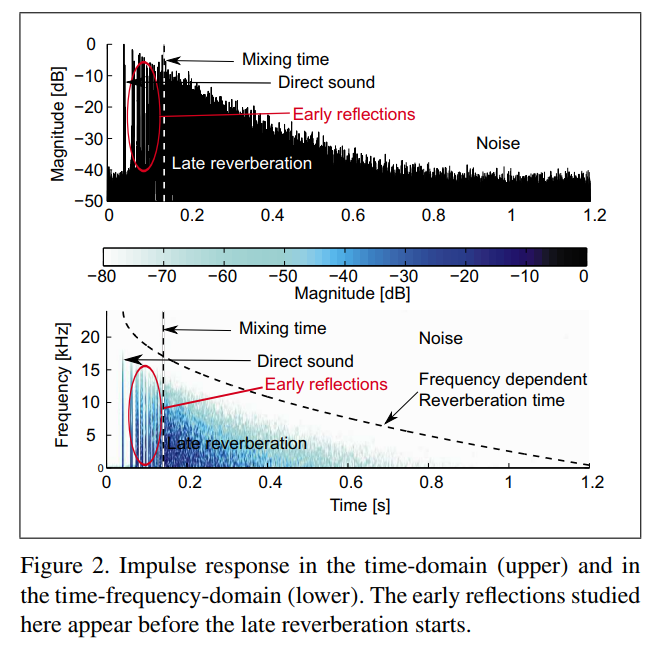

### Energy decay

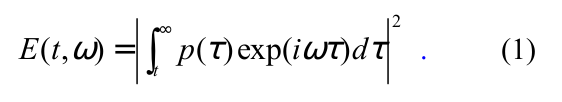

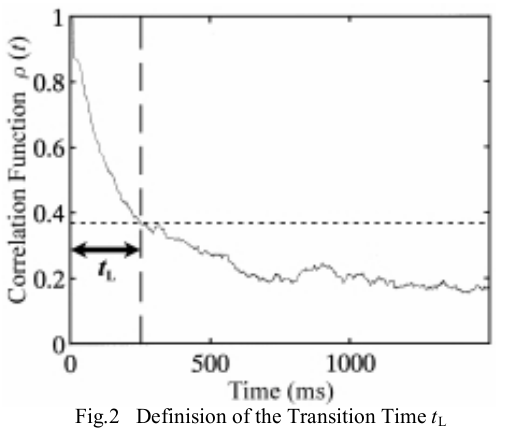

<IPython.core.display.Javascript object>


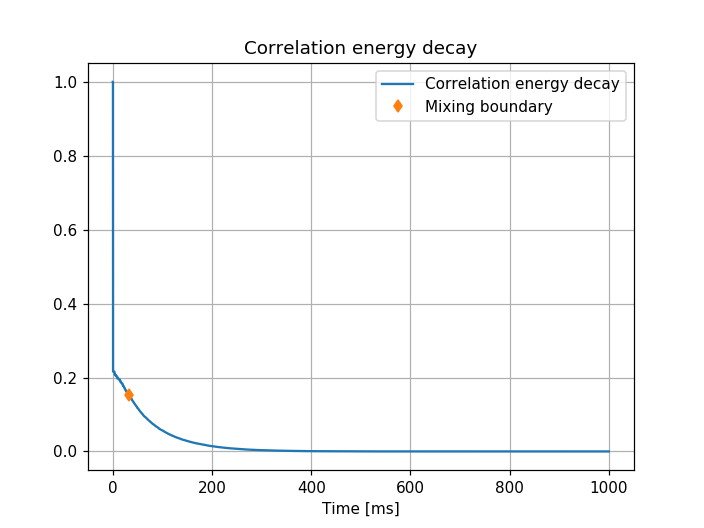

Estimated diffuse time 32.16 [ms]
FFT frames to take 73


In [40]:
te = tvec(df.iloc[0].eRIR,fs)

## Check energy only after direct sound
energy_decay_no_ls = df.iloc[0].eRIR/df.iloc[0].eRIR[np.argmin(te<direct_tau + peak_width_ms)]

imix = np.argmax(energy_decay_no_ls<1/np.sqrt(2))
te_mix = te[imix]
stft_nmix =  int(te_mix*fs/1000/Nhop) # mix in STFT frames to take

plt.figure()
plt.title("Correlation energy decay")
plt.plot(tvec(df.iloc[0].eRIR,fs),df.iloc[0].eRIR,label = "Correlation energy decay")
plt.plot(tvec(df.iloc[0].eRIR,fs)[imix],df.iloc[0].eRIR[imix],'d',label="Mixing boundary")
plt.xlabel('Time [ms]')
plt.legend()
plt.grid()
plt.show()
print("Estimated diffuse time {0:.2f} [ms]".format(te_mix))
print("FFT frames to take {0}".format(stft_nmix))

### Alternative method - Mising time by peak density
1. Test the number of peaks per winodw.
2. Define critical density as the number of correlation width that can reside in the analysis window

In my mind this method is better suited for our purposes

<IPython.core.display.Javascript object>


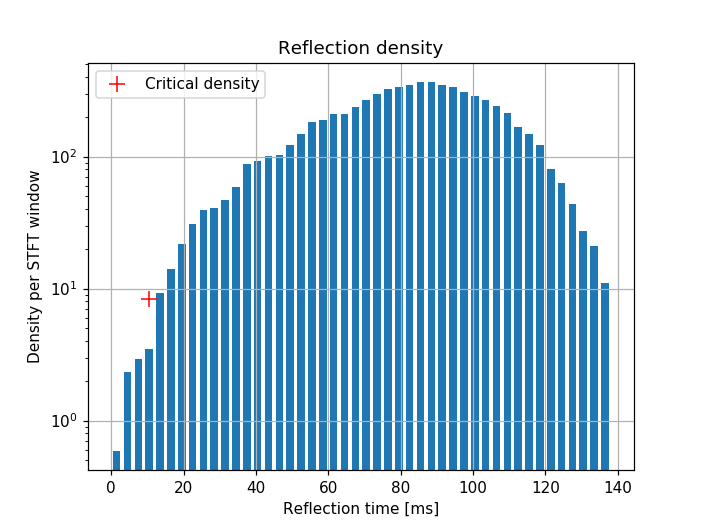

Estimated diffuse time 10.50 [ms]


In [41]:
density_probe_window_ms = 3
time_range = np.arange(0,140,density_probe_window_ms)
density,edges = np.histogram(1000*Taus[0,0]/fs,bins = time_range)
density = window_duration*density/density_probe_window_ms
centers = (edges[:-1] + edges[1:]) / 2

critical_density = window_duration/peak_width_ms #max number of peaks in the window frame

imix = np.argmin(density < critical_density)-1
te_mix = centers[imix]
stft_nmix =  int(te_mix*fs/1000/Nhop) # mix in STFT frames to take

plt.figure()
plt.bar(centers,density,width = 0.7*density_probe_window_ms)
plt.plot(te_mix,critical_density,marker='+',markersize = 10,linestyle='None',
         color = 'r',label="Critical density")
plt.title('Reflection density')
plt.xlabel('Reflection time [ms]')
plt.ylabel('Density per STFT window')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()
print("Estimated diffuse time {0:.2f} [ms]".format(te_mix))


## Window for object location

<IPython.core.display.Javascript object>


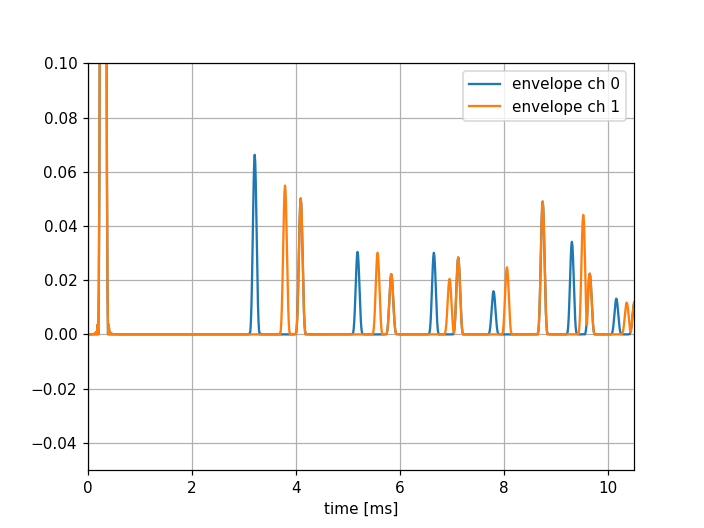

In [42]:
plt.figure()
plt.plot(tvec(df.iloc[0].dRIR,fs),envelope(df.iloc[0].dRIR),label="envelope ch 0")
plt.plot(tvec(df.iloc[1].dRIR,fs),envelope(df.iloc[1].dRIR),label="envelope ch 1")
plt.xlim([0,te_mix])
plt.ylim([-0.05,0.1])
plt.xlabel('time [ms]')
plt.grid()
plt.legend()
plt.show()

## Peak detection

### GCC - PHAT

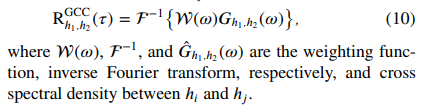


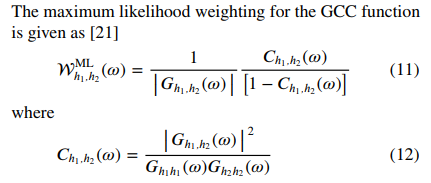

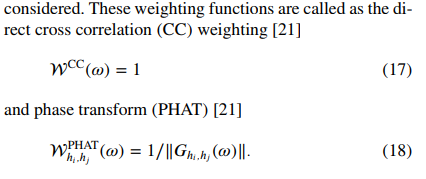

### TOA & TDOA Analysis

In [43]:
def gcc_phat(vec1,vec2):
    regularization = 1e-1 * np.sqrt(np.max(np.abs(vec1)*np.abs(vec2)))
    vec1n = vec1/(np.abs(vec1) + regularization)
    vec2n = vec2/(np.abs(vec2) + regularization)
    return (vec1n * vec2n.conj())

In [44]:
cc = gcc_phat(df.iloc[0].stft_dRIR,df.iloc[1].stft_dRIR)
_,icc = signal.istft(cc,nperseg=Nfft,noverlap=0,input_onesided = False)
icc = icc.reshape(-1,Nfft).T    

<IPython.core.display.Javascript object>


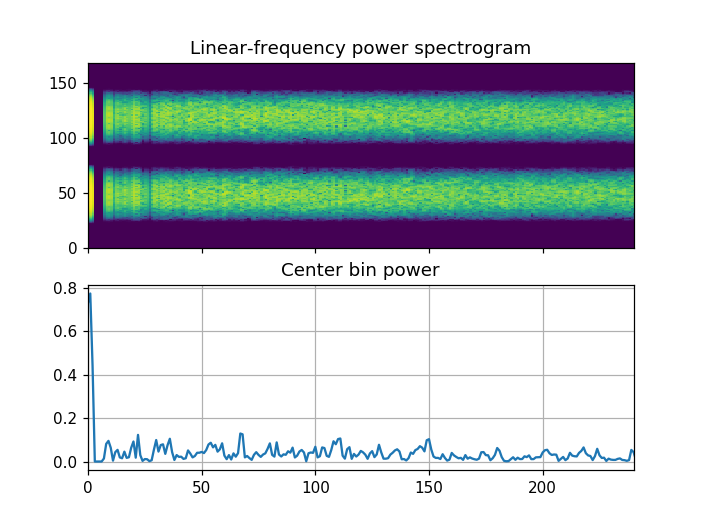

In [45]:
D = to_db(cc)
center_bin = int((Nfft*(fmax-fmin))/fs)
fig, (ax0,ax1) = plt.subplots(2,1,sharex=True)
ax0.pcolormesh(D-np.max(D))
ax0.set_title('Linear-frequency power spectrogram')

ax1.set_title('Center bin power')
ax1.plot(np.abs(cc[center_bin,:]))
ax1.grid()
plt.xlim([0,stft_nmix*10])
plt.plot()
plt.show()

<IPython.core.display.Javascript object>


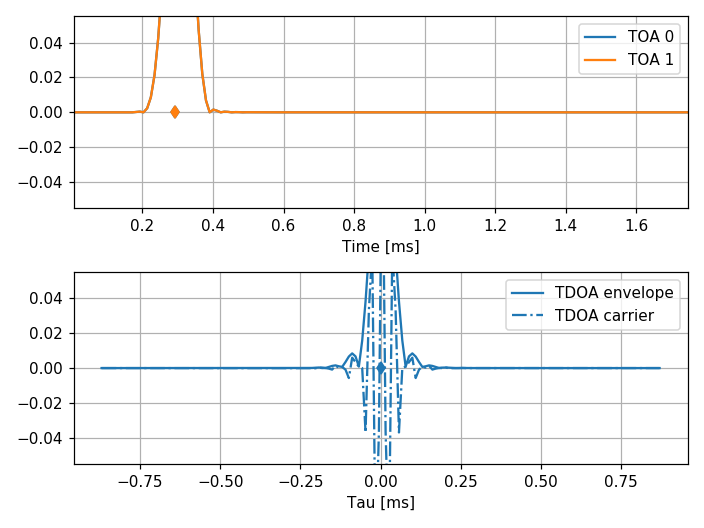

interactive(children=(IntSlider(value=0, description='idx', max=24), Output()), _dom_classes=('widget-interact…

<function __main__.update(idx=0)>

In [46]:
tcc = tvec(np.arange(Nfft),fs,True)
t_off = 1000*Nfft/fs/2

fig, (ax0,ax1) = plt.subplots(2,1)
l1, = ax0.plot(tcc+t_off,[0]*len(tcc),label='TOA 0')

ax0.plot(df[(df.rcv==0) & (df.src==0)].TAU.iloc[0],
         [0]*len(df[(df.rcv==0) & (df.src==0)].TAU.iloc[0]),'d',
         color = l1.get_color())

l2, = ax0.plot(tcc+t_off,[0]*len(tcc),label='TOA 1')
ax0.plot(df[(df.rcv==1) & (df.src==0)].TAU.iloc[0],
         [0]*len(df[(df.rcv==1) & (df.src==0)].TAU.iloc[0]),'d',
         color = l2.get_color())

ax0.set_xlabel('Time [ms]')
ax0.legend()
ax0.grid()

l3, = ax1.plot(tcc,[0]*len(tcc),label='TDOA envelope')
l4, = ax1.plot(tcc,[0]*len(tcc),label='TDOA carrier',
               color = l3.get_color(),linestyle='-.')
l5, = ax1.plot([],[],'d',color=l3.get_color())

ax1.legend()
ax1.set_xlabel('Tau [ms]')
ax1.grid()
plt.tight_layout()
plt.show()

def update(idx = 0):
    icc = np.fft.fftshift(np.fft.ifft(cc[:,idx+2]))
    t_off = 1000*idx*Nhop/fs + 1000*Nfft/fs/2
    
    tau0 = df[(df.rcv==0) & (df.src==0)].TAU.iloc[0]
    tau1 = df[(df.rcv==1) & (df.src==0)].TAU.iloc[0]
    
    tau0_cutoff = tau0[(tau0 > (t_off + tcc.min())) & 
                            (tau0 < (t_off + tcc.max()))]

    tau1_cutoff = tau1[(tau1 > (t_off + tcc.min())) & 
                        (tau1 < (t_off + tcc.max()))]
    
    
    true_tau_diff = tau0_cutoff-tau1_cutoff
#     print(true_tau_diff)
    
    l1.set_data(tcc+t_off,envelope(df.iloc[0].framed_RIR[:,idx]))
    l2.set_data(tcc+t_off,envelope(df.iloc[1].framed_RIR[:,idx]))
    l3.set_ydata(envelope(np.real(icc)))
    l4.set_ydata(np.real(icc))
    
    l5.set_data(true_tau_diff,[0]*len(true_tau_diff))
    
    
    ax0.set_xlim([t_off+tcc.min(),t_off+tcc.max()])
    
interact(update,idx=(0,stft_nmix,1))


In [47]:
## Peak finding
# scipy.signal.find_peaks

## Localization

### Global MLE solution

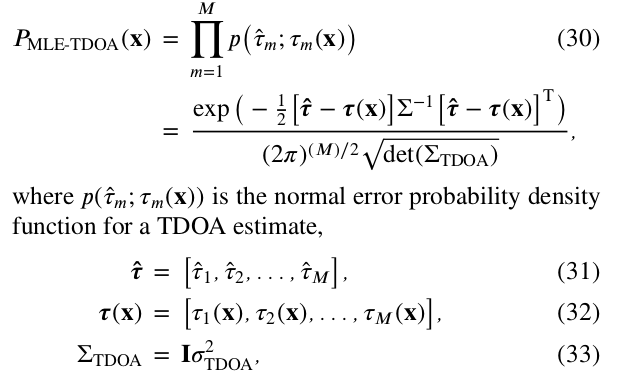

Where $M$ is the number of all possible mic combinations

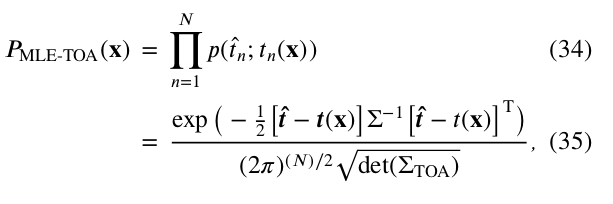

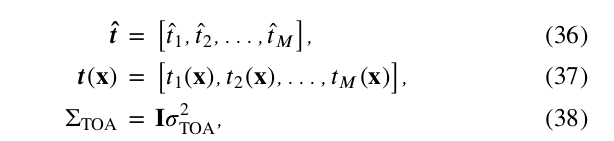

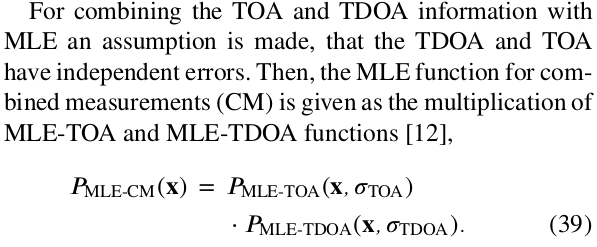

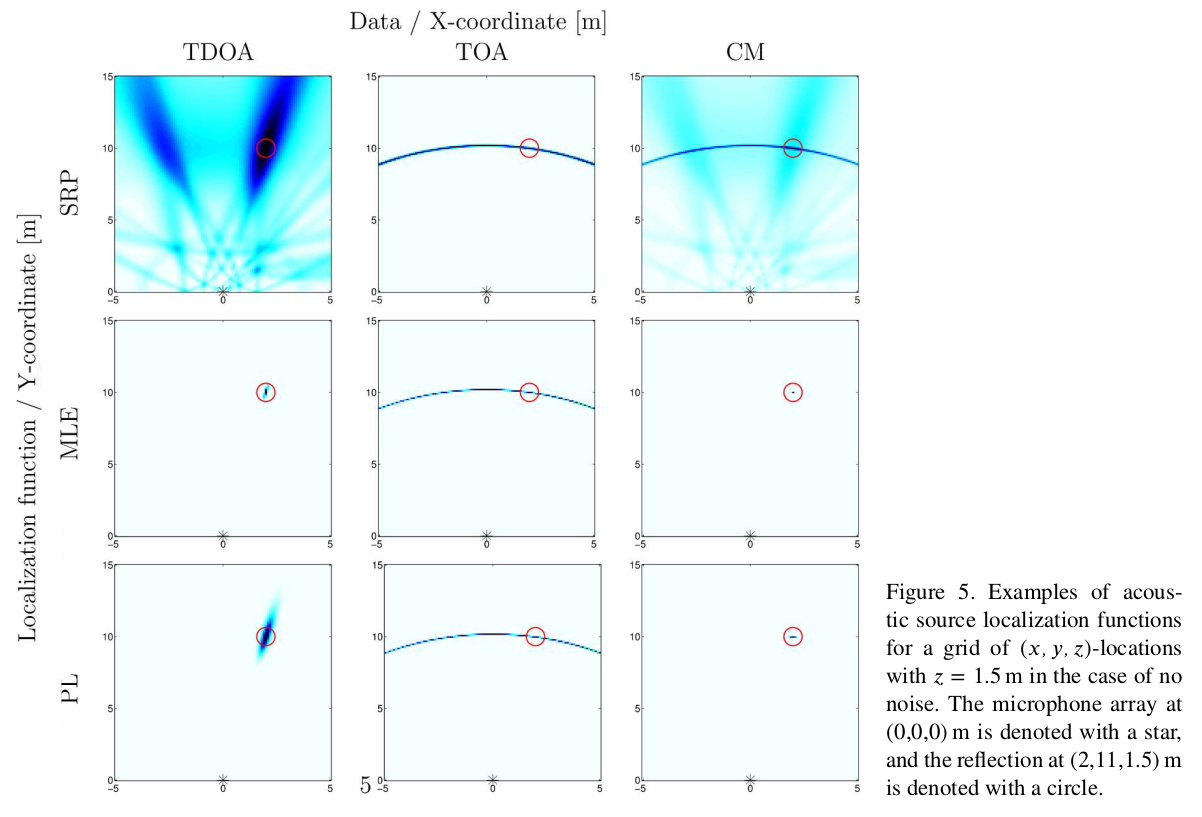

Emil's notes: This case is trivial and not interesting but it presents the "problem"
1. There's only one reflector
2. There's no noise. 
3. Examining the TDOA the peak is unrealistic. It's only possible if there's substantial $\phi_2$ or no noise at all. From my experience when the distance is 2x the aperture $\phi_2$ drops like crazy 

## Image method

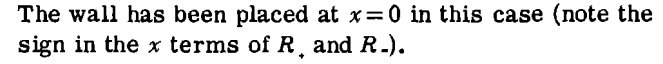

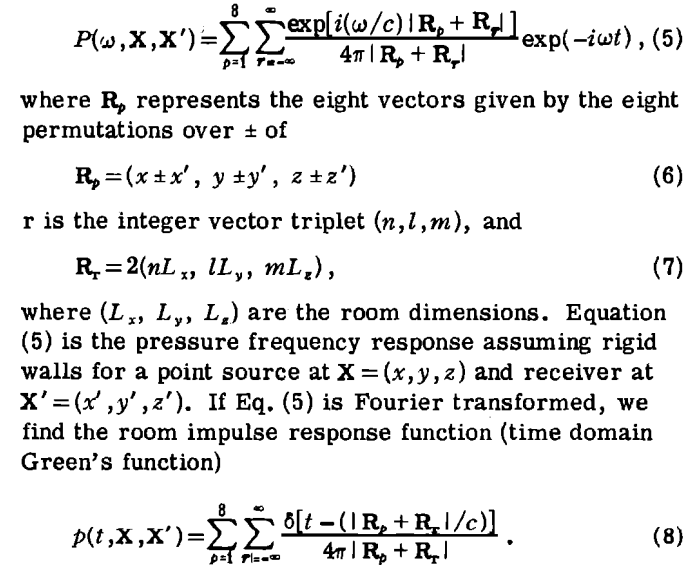

Emil's note: This assumes that the walls meet at (0,0,0)

### optimization -  My suggestion

1. Find all channel peaks in the pre mixing range
2. Find all TDOA peaks 
3. Per RoomSize = {Lx,Ly,Lz}, Array orientation = {$\theta_x$,$\theta_y$,$\theta_z$} and Array center = {x,y,z} find the minimum cost of:
    a. Find possible reflection TAUs by geometry
    b. Do linear assignment - Hungarian
    c. Find L1 cost


In [57]:
def get_tau_set(src,tar,reflection_orders,rm_dims):
    def triplet_combinations(base_vec):
        vec = np.stack(np.meshgrid(base_vec,base_vec,base_vec))
        vec = np.stack(np.meshgrid(base_vec,base_vec,base_vec))
        return vec.reshape(3,len(base_vec)**3).T

    tau_test = []
    for sgn_line in triplet_combinations([-1,1]):
        rp = src + sgn_line*tar
        for nlm in triplet_combinations(reflection_orders):
            rr = 2*nlm*rm_dims
            t = np.linalg.norm(rp+rr)/343
            tau_test.append(t)
    tau_test = np.array(tau_test)
    return tau_test

# tau_test    =  get_tau_set(pos_src,pos_rcv[0],
#                            np.arange(-2,3),room_sz)

tau0_cutoff =  df[(df.rcv==0) & (df.src ==0)].TAU.iloc[0]\
    [(df[(df.rcv==0) & (df.src ==0)].TAU.iloc[0] < te_mix) & \
     (df[(df.rcv==0) & (df.src ==0)].TAU.iloc[0] > direct_tau + peak_width_ms)]

tau1_cutoff =  df[(df.rcv==1) & (df.src ==0)].TAU.iloc[0]\
    [(df[(df.rcv==1) & (df.src ==0)].TAU.iloc[0] < te_mix) & \
     (df[(df.rcv==1) & (df.src ==0)].TAU.iloc[0] > direct_tau + peak_width_ms)]


In [172]:
np.random.choice(tau0_cutoff,5)

array([8.75121354, 5.19081445, 9.31576953, 9.31576953, 6.65464258])

In [ ]:
tau

In [166]:
%%time

jitter_tau_ms = peak_width_ms/5
drop_rate = 0.1
additiona_rate = 0.1

def cost_func(s_pos):
    # Target positions
    t_pos0 = s_pos + pos_rcv[0] - pos_src 
    t_pos1 = s_pos + pos_rcv[1] - pos_src

    tau_test0 = get_tau_set(s_pos,t_pos0,np.arange(-2,3),room_sz)
    tau_test1 = get_tau_set(s_pos,t_pos1,np.arange(-2,3),room_sz)
    
    tau_test0 = 1000*tau_test0[1000*tau_test0<te_mix]
    tau_test1 = 1000*tau_test1[1000*tau_test1<te_mix]

    ### Add jitter 
    tau_test0 += jitter_tau_ms * np.random.randn(*tau_test0.shape)
    tau_test1 += jitter_tau_ms *np.random.randn(*tau_test1.shape)
    
    ## Add drops
    
    
    tau_stack0 = np.stack(np.meshgrid(tau0_cutoff,tau_test0))
    tau_stack1 = np.stack(np.meshgrid(tau1_cutoff,tau_test1))
    
    ## L1 criteria
    cost0 = np.abs(np.diff(tau_stack0,axis=0)).squeeze()
    cost1 = np.abs(np.diff(tau_stack1,axis=0)).squeeze()
    
    ## L2 criteria
#     cost0 = np.abs(np.diff(tau_stack0,axis=0)**2).squeeze()
#     cost1 = np.abs(np.diff(tau_stack1,axis=0)**2).squeeze()
    
    ## Linear assignment solution
    row_ind0, col_ind0 = linear_sum_assignment(cost0)
    row_ind1, col_ind1 = linear_sum_assignment(cost1)
    
    loss = cost0[row_ind0, col_ind0].sum() + cost1[row_ind1, col_ind1].sum()
    return loss   


## Optimal 2D positioning
res = 0.1
x_range = np.arange(0,3.5,res)
y_range = np.arange(0,3.5,res)

xyz = np.stack(np.meshgrid(x_range,y_range,[1]))
xyz = xyz.reshape(3,-1).T


## Optimal 2D positioning -  single process
# loss_result = np.zeros(len(xyz))
# for idx, s_pos in enumerate(xyz):
#     loss = cost_func(s_pos)
#     loss_result[idx] = loss

## Optimal 2D positioning -  multiprocessing
with Pool(processes=6) as pool:
    loss_result = pool.starmap(cost_func, zip(xyz))

    
loss_result = np.array(loss_result).reshape(len(x_range),len(y_range))

CPU times: user 21.1 ms, sys: 97.4 ms, total: 119 ms
Wall time: 8.42 s


<IPython.core.display.Javascript object>


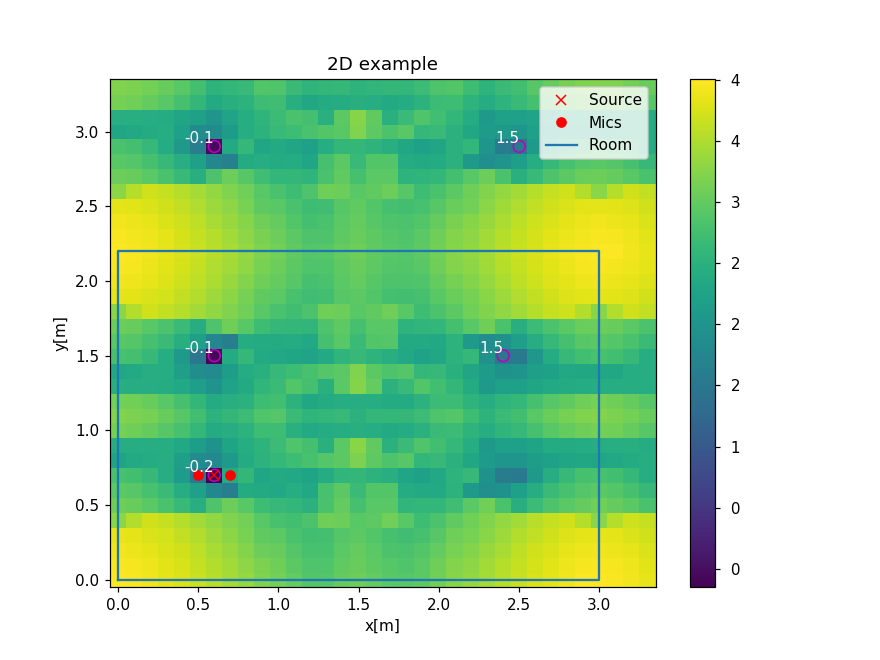

In [167]:
plt.figure(figsize=(8,6))
plt.title("2D example")
plt.pcolor(x_range-res/2,y_range-res/2,np.log(loss_result))
plt.colorbar(format="%2.0f")
# plt.clim(-10,10)
plt.plot(pos_src[:,0],pos_src[:,1],marker='x',color='r',label = 'Source',linestyle='None')
plt.plot(pos_rcv[:,0],pos_rcv[:,1],marker='o',color='r',label = 'Mics',linestyle='None')
plt.plot([0,room_sz[0],room_sz[0],0,0],[0,0,room_sz[1],room_sz[1],0],label='Room')

peaks_2d= peak_local_max(-loss_result,min_distance=5,num_peaks=5)
for pk in peaks_2d:
    llr = np.log(loss_result[pk[0],pk[1]])
    plt.scatter(y_range[pk[1]],x_range[pk[0]], s=60, facecolors='none', edgecolors='m')
    plt.text(y_range[pk[1]],x_range[pk[0]],"{0:.1f}".format(llr),
             verticalalignment='bottom',horizontalalignment = 'right',color='w')

plt.legend()
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.show()

In [51]:
## Optimizer

In [52]:
## Solve the problem with TAUs directly
## Optimize with TDOA
## Optimize room size

## Effect of noise on accuracy, white and diffused
## Find actial peaks in the graph
## Sensitivity - Add / Remove peaks. Jitter peaks. Show analysis
## 2. Find ac


### Summary
1. Room acoustics
    * Early and Late reflections
    * Diffused v.s. Specular
    * Frequency dependence
    * Noise sources
        - Diffused noise $\sin(d)/d$ 
        - White noise - microphone noise floor.
        - Don't know which dominates at 30kHz?
    * Microphone calibration. Phase detireoration
2. Sampling signal
    * Bandwidth
    * Analysis window
    * Energy decay threshold
    * Sampling with the carrier v.s. envelope
    * Optimal STFT window
    *
    
3. TDOA and TOA
    * $\phi_0$ , $\phi_1$, $\phi_2$
    * 
4. Room Localization
    * Radial and angular
    * Ambiguities and ghosts
        - Array ambiguities
        - Localization ghosts        
    * What happens if you only see the from coming peaks...?
